# Classificação de textos do Twitter com spaCy

# Etapa 1: Importação e instalação das bibliotecas

In [ ]:
#!pip install spacy --upgrade
!pip install -q spacy==2.2.3 #Atualizado: 02/05/2021 Obs: utilizar esta versão.

In [ ]:
import spacy
spacy.__version__

'2.2.3'

In [ ]:
!python3 -m spacy download pt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.2 MB 2.7 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=aa128d05d0f30a9404f2ff873073718abaeb79f5900c413cb64aa21de0e11290
  Stored in directory: /tmp/pip-ephem-wheel-cache-2yznu1jx/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [ ]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
import re

# Etapa 2: Carregamento das bases de dados

- Link Kaggle: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis#TweetsNeutralHash.csv

## Base de treinamento

- Negative label: 0
- Positive label: 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_treinamento = pd.read_csv('/content/drive/MyDrive/Mineração e Análise de Dados do LinkedIn/Train50.csv', delimiter=';')

In [ ]:
base_treinamento.shape

(50000, 5)

In [ ]:
base_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [ ]:
base_treinamento.tail()

,id,tweet_text,tweet_date,sentiment,query_used
49995,1046762827053232128,:( é tão lindo que dói https://t.co/GqnpgyWWxB,Mon Oct 01 14:04:40 +0000 2018,0,:(
49996,1046762813362966529,"@veraluciarj Pois é.. tenho problema c/ ""coisa...",Mon Oct 01 14:04:37 +0000 2018,0,:(
49997,1046762806392082432,eu te amo tanto minja vidinha meu bem mais pre...,Mon Oct 01 14:04:35 +0000 2018,0,:(
49998,1046762752071618560,@itsLary @jessboluda Pfvor :(,Mon Oct 01 14:04:22 +0000 2018,0,:(
49999,1046762735340584962,@Renk_lol Passa ano Entra ano Eu nao desisto d...,Mon Oct 01 14:04:18 +0000 2018,0,:(


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


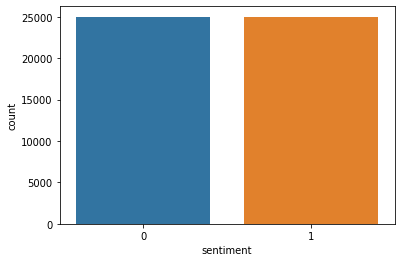

In [ ]:
sns.countplot(base_treinamento['sentiment'], label = 'Contagem');

In [ ]:
base_treinamento.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [ ]:
base_treinamento.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


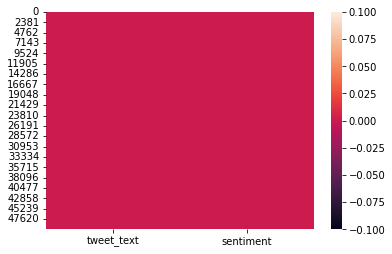

In [ ]:
sns.heatmap(pd.isnull(base_treinamento));

## Base de teste

In [ ]:
base_teste = pd.read_csv('/content/drive/MyDrive/Mineração e Análise de Dados do LinkedIn/Test.csv', delimiter=';')

In [ ]:
base_teste.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [ ]:
base_teste.shape

(5000, 5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


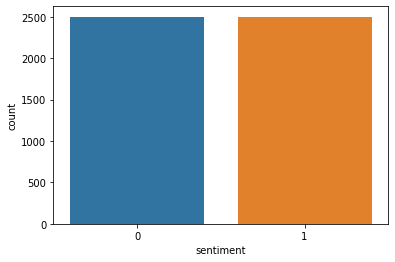

In [ ]:
sns.countplot(base_teste['sentiment'], label='Contagem');

In [ ]:
base_teste.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [ ]:
base_teste.head()

,tweet_text,sentiment
0,@Gazo1a Nossa! Muito obrigada :),1
1,@BerzGamer vai pa puta que te pariu :),1
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1
4,Estávamos em casa do Zé e eu estava a morrer d...,1


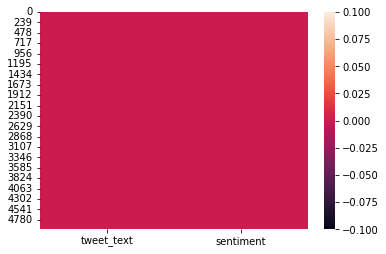

In [ ]:
sns.heatmap(pd.isnull(base_teste));

# Etapa 3: Função para pré-processamento dos textos

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [ ]:
pln = spacy.load('pt')
pln

In [ ]:
base_treinamento['tweet_text'][1]

'@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'

In [ ]:
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

In [ ]:
print(stop_words)

{'ali', 'essas', 'podia', 'cima', 'isso', 'zero', 'próprio', 'primeira', 'esteve', 'tivestes', 'duas', 'apoio', 'tivemos', 'minhas', 'novas', 'forma', 'quero', 'outros', 'dois', 'algo', 'fazer', 'tão', 'uma', 'cento', 'puderam', 'seria', 'quieta', 'custa', 'foste', 'boa', 'quarto', 'fim', 'poderá', 'te', 'breve', 'porquanto', 'máximo', 'lado', 'obrigada', 'caminho', 'próximo', 'segunda', 'depois', 'mesmo', 'pelos', 'aquele', 'algumas', 'inicio', 'teu', 'próxima', 'tu', 'essa', 'nós', 'daquela', 'ponto', 'estivemos', 'vezes', 'de', 'oito', 'comprida', 'irá', 'apenas', 'ambos', 'bem', 'numa', 'quanto', 'cada', 'nesse', 'obrigado', 'meio', 'dezoito', 'nada', 'pelo', 'quinze', 'só', 'cá', 'novos', 'desse', 'contra', 'acerca', 'antes', 'uns', 'isto', 'questão', 'dá', 'daquele', 'vêm', 'sua', 'ou', 'menor', 'dezanove', 'tens', 'até', 'ainda', 'alguns', 'tem', 'grandes', 'quinto', 'põe', 'por', 'posso', 'sob', 'aquela', 'oitavo', 'tendes', 'ela', 'partir', 'suas', 'tentar', 'vem', 'estava', '

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def preprocessamento(texto):
  # Letras minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto)

  # Emoticons
  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  # Lematização
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)
  
  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return lista

In [ ]:
texto_teste = '@behin_d_curtain :D Para :( mim, http://www.iaexpert.com.br é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'
resultado = preprocessamento(texto_teste)
resultado

'  emocaopositiva parir emocaonegativa mim precisamente o contrário emocaopositiva vir o chuva e vir o disposição emocaopositiva'

# Etapa 4: Pré-processamento da base de dados

### Limpeza dos textos

In [ ]:
base_treinamento.head(10)

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1
5,@KingJokerLeto mas amiga eu to aqui ainda :),1
6,"@RivasJairo Bravo, Jairo!!! :)))",1
7,@inquilinasls @Spotify socorro ksoaksosks acho...,1
8,"@chimekarlla gosto muito de fazenda :) , mas m...",1
9,Amanha vou ver venom :D,1


In [ ]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)

In [ ]:
base_treinamento.head(10)

,tweet_text,sentiment
0,o pessoa certo parir seriar o valer e azeved...,1
1,parir mim precisamente o contrário emocaopos...,1
2,video hoje ... pensar falar sobrar o meter csg...,1
3,aaaaaaaa amar polaroids expressar o quantum to...,1
4,valorizar o coração menino vc diferente o sorr...,1
5,amigo to emocaopositiva,1
6,bravo jairo emocaopositiva,1
7,socorrer ksoaksosks achar to o caixa som :p,1
8,gostar fazenda emocaopositiva morrer medo ga...,1
9,amanhar venom emocaopositiva,1


In [ ]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

In [ ]:
base_teste.head(10)

,tweet_text,sentiment
0,obrigar emocaopositiva,1
1,pa puta parir emocaopositiva,1
2,querer desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 conferir o l...,1
3,vcs ajudar galera pelar amor butera emocaoposi...,1
4,casar zé e o morrer sono chegar o casar e fica...,1
5,preciso emocaopositiva,1
6,acaso adorar beijo e abraço hahahahaha bue f...,1
7,solteiro s emocaopositiva,1
8,lindeza cortador kit mário coleção bia cravol ...,1
9,claro emocaopositiva,1


### Tratamento da classe

In [ ]:
exemplo_base_dados = [["este trabalho é agradável", {"POSITIVO": True, "NEGATIVO": False}],
                      ["este lugar continua assustador", {"POSITIVO": False, "NEGATIVO": True}]]

In [ ]:
base_dados_treinamento_final = []
for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emocao == 1:
    dic = ({'POSITIVO': True, 'NEGATIVO': False})
  elif emocao == 0:
    dic = ({'POSITIVO': False, 'NEGATIVO': True})

  base_dados_treinamento_final.append([texto, dic.copy()])

In [ ]:
len(base_dados_treinamento_final)

50000

In [ ]:
base_dados_treinamento_final[10:15]

[['simplesmente o deixar chatear querer muitooo e iludir emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['o comedir umar rotina e perfeitamente parir consolidar o escola condução :p',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['amigar parecer apaixonar vc — recíproco emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['  gajar bacano aleijar esperar e o silvar feliz emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['tou o video cabra bebé emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}]]

In [ ]:
base_dados_treinamento_final[45000:45005]

[['o menino pijama listrar o filmar triste mundo estruturar nenhum pra assistir rever e to pensar n emocaonegativa',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['pra o vídeo luísa raiz o poliana infelizmente o twitter tá ruim amanhã postar emocaonegativa asaventurasdepoliana099',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['to crise abstinência strangers emocaonegativa — tbm :/ to',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['  esquecer olhar pra pagar o mensalidade turma pro cursar querer emocaonegativa',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['querer comer doce comer montar hoje emocaonegativa maldição',
  {'POSITIVO': False, 'NEGATIVO': True}]]

# Etapa 5: Criação do classificador

In [ ]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
modelo.add_pipe(categorias)
historico = []

In [ ]:
modelo.begin_training()
for epoca in range(20):
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0:
    print(losses)

{'textcat': 9.71105674945072e-05}
{'textcat': 2.1756565186242804e-07}
{'textcat': 1.6183073395757697e-07}
{'textcat': 1.4771382679523715e-07}


In [ ]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [ ]:
historico_loss = np.array(historico_loss)
historico_loss

array([9.71105675e-05, 9.71105675e-05, 9.71105675e-05, ...,
       1.32724157e-07, 1.32724157e-07, 1.32724157e-07])

Text(0, 0.5, 'Erro')

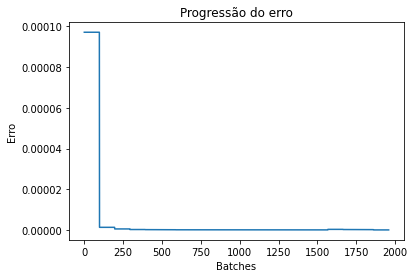

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [ ]:
modelo.to_disk("modelo")

# Etapa 6: Testes com uma frase

In [ ]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

## Texto positivo

In [ ]:
texto_positivo = base_teste['tweet_text'][21]
texto_positivo

'  ficar feliz q recíproco emocaopositiva'

In [ ]:
previsao = modelo_carregado(texto_positivo)
previsao

  ficar feliz q recíproco emocaopositiva

In [ ]:
previsao.cats

{'POSITIVO': 0.9994398951530457, 'NEGATIVO': 0.000394783157389611}

In [ ]:
texto_positivo = 'eu gosto muito de você'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'gostar'

In [ ]:
modelo_carregado(texto_positivo).cats

{'POSITIVO': 0.6685715317726135, 'NEGATIVO': 0.08687078952789307}

## Texto negativo

In [ ]:
base_teste['tweet_text'][4000]

'tô triste filmar mulan o mushu emocaonegativa'

In [ ]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'POSITIVO': 0.0007269387133419514, 'NEGATIVO': 0.9985792636871338}

# Etapa 7: Avaliação do modelo

## Avaliação na base de treinamento


In [ ]:
previsoes = []
for texto in base_treinamento['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes

[{'POSITIVO': 0.9993320107460022, 'NEGATIVO': 0.0005987309850752354},
 {'POSITIVO': 0.9996298551559448, 'NEGATIVO': 0.00018541781173553318},
 {'POSITIVO': 0.9996886253356934, 'NEGATIVO': 0.00033759590587578714},
 {'POSITIVO': 0.9996922016143799, 'NEGATIVO': 0.0005254305433481932},
 {'POSITIVO': 0.9997338652610779, 'NEGATIVO': 0.00021747927530668676},
 {'POSITIVO': 0.9994124174118042, 'NEGATIVO': 0.00018430435738991946},
 {'POSITIVO': 0.998855471611023, 'NEGATIVO': 0.0012286525452509522},
 {'POSITIVO': 0.999550998210907, 'NEGATIVO': 0.00012156380398664623},
 {'POSITIVO': 0.9994434714317322, 'NEGATIVO': 0.0005190238007344306},
 {'POSITIVO': 0.9994365572929382, 'NEGATIVO': 0.0004190955660305917},
 {'POSITIVO': 0.9997610449790955, 'NEGATIVO': 0.00024164185742847621},
 {'POSITIVO': 0.9996286630630493, 'NEGATIVO': 0.00015086344501469284},
 {'POSITIVO': 0.999411940574646, 'NEGATIVO': 0.0003441198787186295},
 {'POSITIVO': 0.999627947807312, 'NEGATIVO': 0.00012196517491247505},
 {'POSITIVO': 0.

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [ ]:
previsoes_final

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
respostas_reais = base_treinamento['sentiment'].values
respostas_reais

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
len(respostas_reais)

50000

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final)

0.99942

In [ ]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[24998,     2],
       [   27, 24973]])

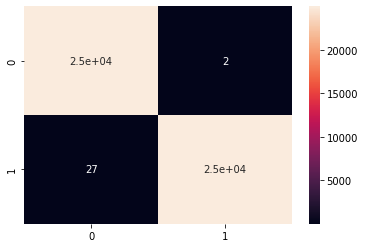

In [ ]:
sns.heatmap(cm, annot=True)

## Avaliação na base de teste

In [ ]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [ ]:
respostas_reais = base_teste['sentiment'].values

In [ ]:
accuracy_score(respostas_reais, previsoes_final)

0.9954

In [ ]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2492,    8],
       [  15, 2485]])

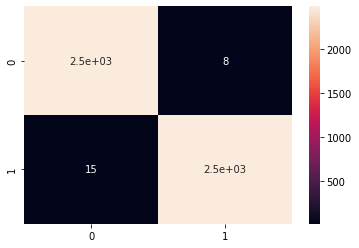

In [ ]:
sns.heatmap(cm, annot=True)